**DM simulation:**

    See notes at end of code for mathematical reasoning and derivations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
# essential imports

<class 'astropy.convolution.kernels.Gaussian2DKernel'>


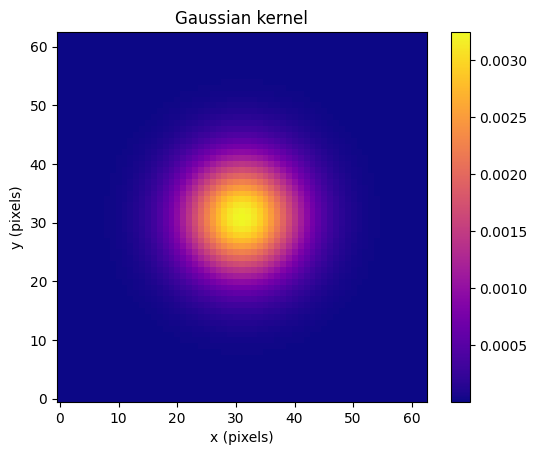

In [2]:
# creates Gaussian beam kernel & plots it
size = 7
gaussian_kernel = Gaussian2DKernel(size, size, x_size=9*size)
plt.imshow(gaussian_kernel, origin = 'lower', cmap='plasma')
plt.colorbar()
plt.title("Gaussian kernel")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
print(type(gaussian_kernel))

Total number of actuators: 256


Text(0, 0.5, 'y (pixels)')

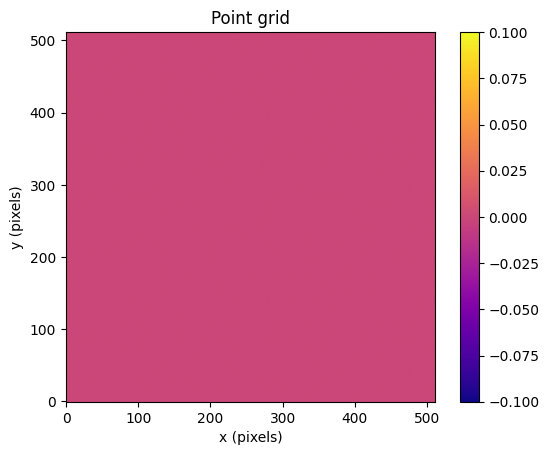

In [15]:
n = 512 # number of pixels
dist = 32 # distance between points
mid = int(dist/2) # ensures centering of points

Z = np.zeros((n, n))
actuator_number = 0

for i in range(mid, n, dist):
    for j in range(mid, n, dist):
        Z[i, j] = 0#2 * np.random.rand() - 1 #change this value with 0 to produce a flat DM
        actuator_number = actuator_number + 1
# creates Dirac comb with random points and plots it

plt.imshow(Z, origin='lower', cmap='plasma')
plt.colorbar()
print("Total number of actuators:", actuator_number)
plt.title("Point grid")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

Text(0.5, 1.0, 'Gaussian grid')

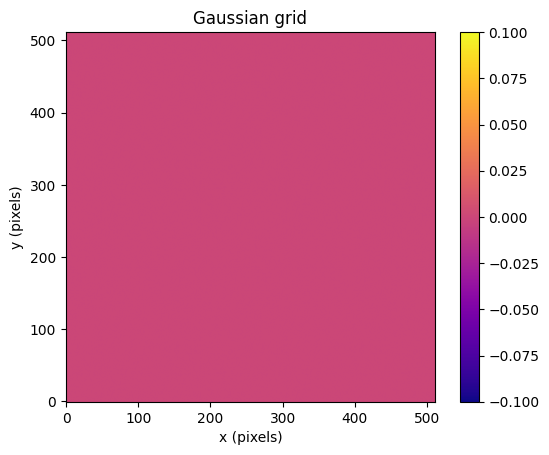

In [16]:
# convolves Dirac comb with Gaussian kernel
grid_convolved = convolve(Z, gaussian_kernel)
plt.imshow(grid_convolved, origin='lower', cmap='plasma')
plt.colorbar()
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title("Gaussian grid")

Text(0, 0.5, 'y (pixels)')

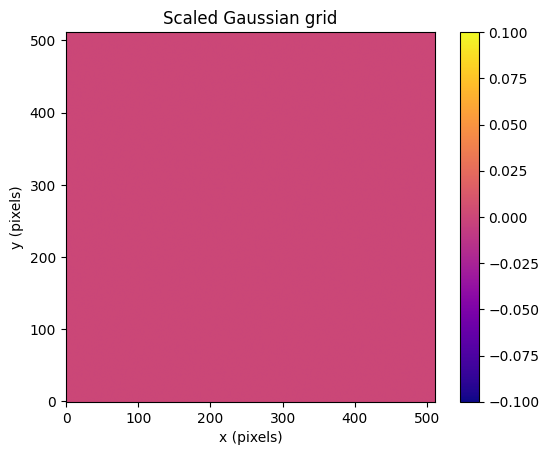

In [17]:
# scales Gaussian grid to appropriate phase bounds

min_val = -np.pi # minimum phase value
max_val = np.pi # maximum phase value

grid_convolved_min = grid_convolved.min() # finds minimum and maximum of grid from above
grid_convolved_max = grid_convolved.max()

scaled_dm = grid_convolved # uncomment this, and comment next line if dealing with flat DM.

#scaled_dm = (grid_convolved - grid_convolved_min) * (max_val - min_val)/(grid_convolved_max - grid_convolved_min) + min_val
# scales the grid to the phase bounds clarified above

# plots the  scaled grid
plt.imshow(scaled_dm, origin='lower', cmap="plasma")
plt.colorbar()
plt.title("Scaled Gaussian grid")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

Text(0, 0.5, 'y (pixels)')

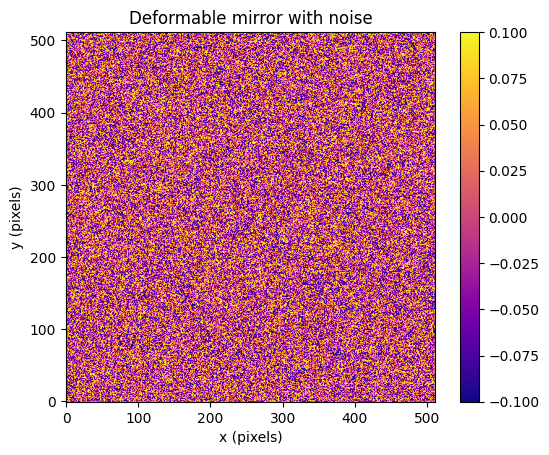

In [18]:
# adds random noise to grid from above

mean = 0
std_dev = 0.5
lower, upper = -0.1, 0.1
noise = np.random.normal(loc = mean, scale = np.abs(std_dev), size = scaled_dm.shape)
# creates random noise based on bell curve

# clips noise to provided ranges
noise = np.clip(noise, lower, upper)

# adds noise to DM
scaled_dm = scaled_dm + noise
scaled_dm = np.clip(scaled_dm, min_val, max_val)
plt.imshow(scaled_dm, origin = 'lower', cmap = "plasma")
plt.colorbar()
plt.title("Deformable mirror with noise")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

d_length: 20.480000000000018
d_lower: 245.76
d_upper: 266.24
d_avg: 256.0


[NbConvertApp] Converting notebook Fourf_optical_system_simulation_v1.ipynb to script
[NbConvertApp] Writing 9163 bytes to Fourf_optical_system_simulation_v1.py


d_length: 20.480000000000018
d_lower: 245.76
d_upper: 266.24
d_avg: 256.0


[NbConvertApp] Converting notebook Fourf_optical_system_simulation_v1.ipynb to script
[NbConvertApp] Writing 9163 bytes to Fourf_optical_system_simulation_v1.py


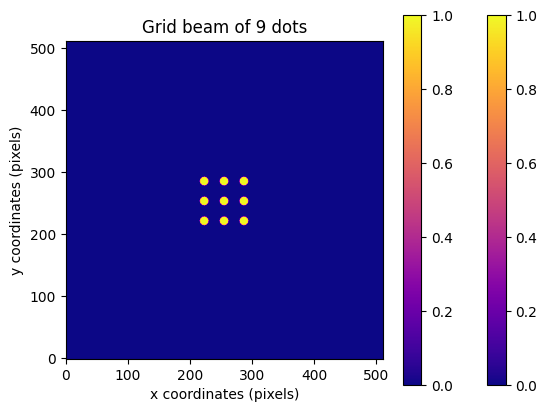

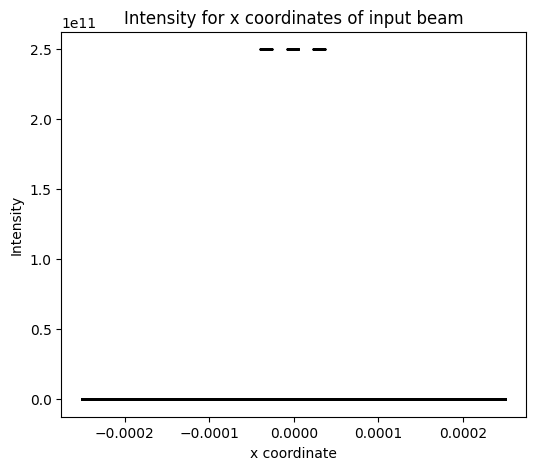

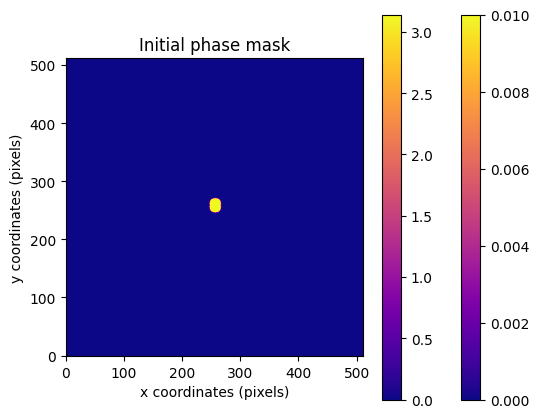

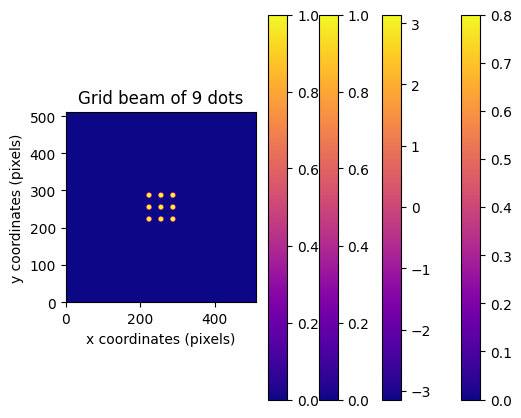

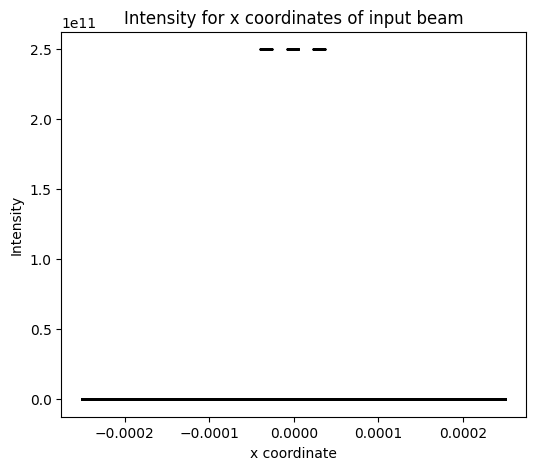

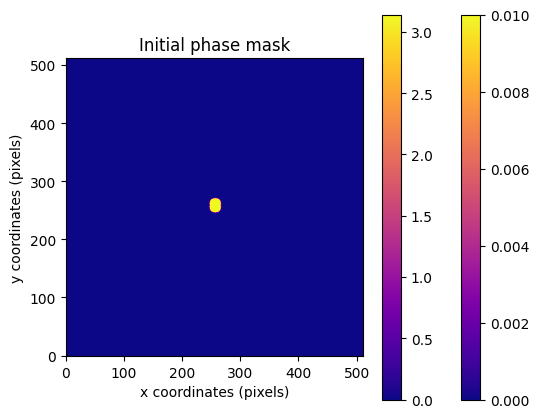

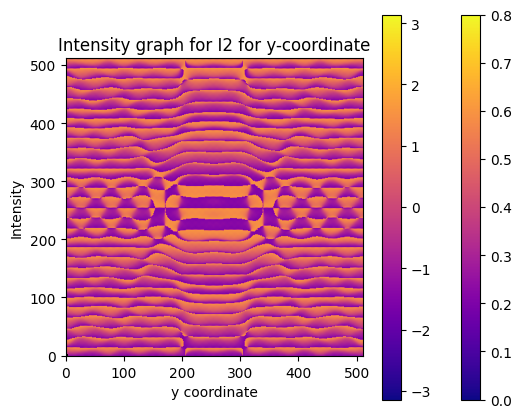

In [8]:
import importlib
import Fourf_optical_system_simulation_v1
importlib.reload(Fourf_optical_system_simulation_v1)
u2 = fftshift(Fourf_optical_system_simulation_v1.u2)
# imports final propagated map from 4f simulation

Text(0, 0.5, 'y coordinates (pixels)')

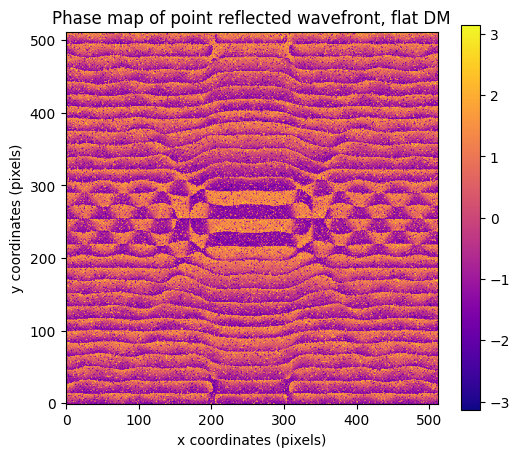

In [19]:
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
wvl = 200e-9 # wavelength
k=2*np.pi/wvl # wavenumber
# same conditions as from 4f simulation

# reflects wavefront off of DM
reflected_wf = u2*np.exp(1j*k*2*scaled_dm)

plt.figure(figsize=(6,5))
# plots phase map of reflection
plt.imshow(np.angle(reflected_wf), cmap='plasma', origin = 'lower')
#plt.clim(0, 0.001)
plt.colorbar()
plt.title("Phase map of point reflected wavefront, flat DM")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'y coordinates (pixels)')

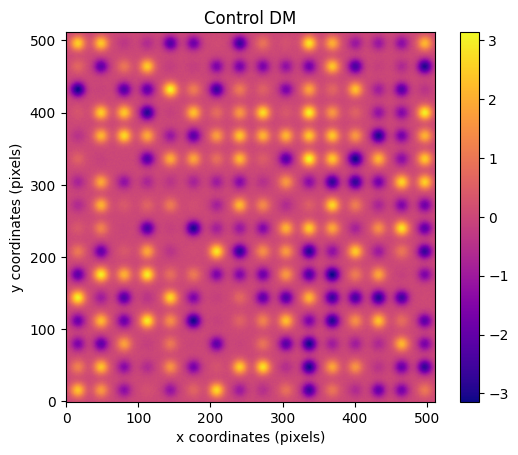

In [21]:
control_points = np.zeros((n,n))
# generates random control matrix, as done for DM
for i in range(mid, n, dist):
    for j in range(mid, n, dist):
        control_points[i, j] = 2 * np.random.rand() - 1

control = convolve(control_points, gaussian_kernel)
control = (control - np.min(control)) * (max_val - min_val)/(np.max(control) - np.min(control)) + min_val
# convolves with Gaussian kernel, and scales to appropriate phase range.

noise_control = np.random.normal(loc = mean, scale = np.abs(std_dev*scaled_dm), size = scaled_dm.shape)
noise_control = np.clip(noise_control,-0.1, 0.1)
# creates noise matrix within appropriate range

control = control + noise_control
control = np.clip(control, -np.pi, np.pi)
# adds noise and adjusts to approprate phase range

#plots graph of control matrix
plt.imshow(control, origin='lower', cmap = 'plasma')
plt.colorbar()
plt.title("Control DM")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")


Text(0, 0.5, 'y coordinate (pixels)')

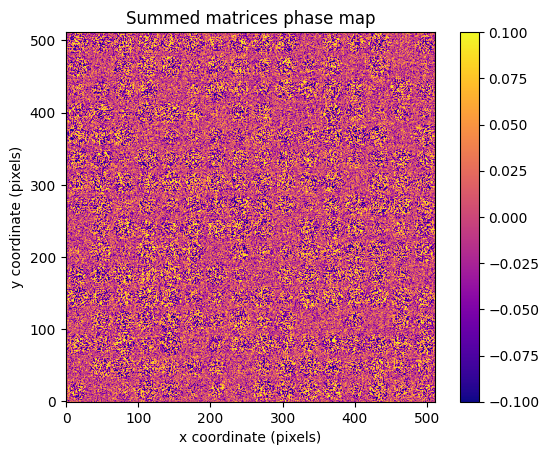

In [12]:
sumMatrix = 1*control+scaled_dm

# ensures sumMatrix is within phase bounds
for i in range(mid, n, dist):
    for j in range(mid, n, dist):
        if sumMatrix[i, j] > np.pi:
                sumMatrix[i,j] = sumMatrix[i,j] - 2*np.pi
        elif sumMatrix[i, j] < -np.pi:
                sumMatrix[i,j] = sumMatrix[i,j] + 2*np.pi
sumMatrix = np.clip(sumMatrix, -np.pi, np.pi)

#sumMatrix = (sumMatrix + np.pi) % (2*np.pi)-np.pi
plt.imshow(sumMatrix, origin= 'lower', cmap='plasma')
plt.colorbar()
#plt.clim(-np.pi, np.pi)
plt.title("Summed matrices phase map")
plt.xlabel("x coordinate (pixels)")
plt.ylabel("y coordinate (pixels)")

Text(0, 0.5, 'y coordinates (pixels)')

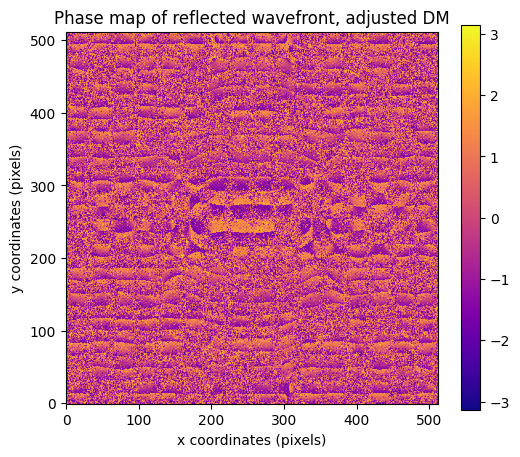

In [20]:
# reflects wavefront off of adjusted DM, and plots
adjusted_wf = u2*np.exp(1j*k*2*sumMatrix)

plt.figure(figsize=(6,5))

plt.imshow(np.angle(adjusted_wf), cmap='plasma', origin = 'lower')
#plt.imshow(I_normalised, cmap='plasma', origin='lower')
#plt.clim(0, 0.01)
plt.colorbar()
plt.title("Phase map of reflected wavefront, adjusted DM")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

**Notes:**
 
 Let the DM matrix be $h(x,y)$. Then, since light has to go to mirror and reflect, the optical path different (OPD) is
 $$OPD = 2h(x,y).$$
 Phase shift is thus
 $$\delta(x,y) = \frac{2\pi}{\lambda}OPD$$
 $$ = \frac{4\pi}{\lambda}h(x,y).$$

 Hence, reflected light beam is
 $$u_\text{reflected} = u_\text{incident} e^{\frac{4i\pi}{\lambda}h(x,y)}.$$

 As for the control matrices, they are calculated by
 $$M_{ij} = \frac{1}{2}C_{ij} + D_{ij},$$
 where $C$ is the control matrix, $D$ is the DM matrix, $M$ is the summed, adjusted matrix, and $\frac{1}{2}$ is the scaling factor.
 Hence, if we have a noise matrix $N$,
 $$M_{i,j} = \frac{1}{2} \left( C_{i,j} + N_{i,j}\right) + D_{i,j}.$$
We can reflect the adjusted matrix, as done above for the DM.


The steps in using the DM are:
1. Create random matrix of DM.
2. Reflect incident light beam, which is from 4f system.
3. Image reflection.
4. Use control matrices to modify DM.
5. Reflect light of modified DM.